In [ ]:
!pip install torch torchvision

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from collections import Counter

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 20
learning_rate = 1.4e-4

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # Class weights (for imbalance), can be a Tensor

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


In [4]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)),  # ResNet-50 expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # from pretrained weights on ImageNet
])
train_dataset = ImageFolder(root='/media/DiscoLocal/IPCV/Carolina/classification/image_train', transform=transform)
val_dataset = ImageFolder(root='/media/DiscoLocal/IPCV/Carolina/classification/image_query', transform=transform)
test_dataset = ImageFolder(root='/media/DiscoLocal/IPCV/Carolina/classification/image_test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)

# Compute class weights (optional, for severe imbalance)
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total = sum(class_counts.values())
weights = torch.tensor([total / class_counts[i] for i in range(num_classes)], dtype=torch.float)
weights = weights.to(device)

In [18]:
def training_loop(model, criterion, optimizer, train_loader, val_loader):
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

        # validate
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert logits to probabilities
                probs = F.softmax(outputs, dim=1)  # shape: [batch_size, num_classes]

                # Get predicted class and confidence
                _, preds = torch.max(probs, dim=1)  # both are [batch_size]

                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        print(f"            Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


In [19]:
# Model setup
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in model.fc.parameters():
    param.requires_grad = True


model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Focal Loss and optimizer
criterion = FocalLoss(gamma=2.0, weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_loop(model, criterion, optimizer, train_loader, val_loader)

/media/DiscoLocal/IPCV/Carolina/UrbanElementsREID/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/DiscoLocal/IPCV/Carolina/UrbanElementsREID/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 2.5275
            Val Loss: 2.3282 | Val Acc: 70.85%
Epoch [2/20], Loss: 1.6776
            Val Loss: 1.7771 | Val Acc: 70.35%
Epoch [3/20], Loss: 1.2282
            Val Loss: 1.5192 | Val Acc: 69.85%
Epoch [4/20], Loss: 0.9885
            Val Loss: 1.3349 | Val Acc: 70.85%
Epoch [5/20], Loss: 0.8370
            Val Loss: 1.2065 | Val Acc: 72.36%
Epoch [6/20], Loss: 0.7300
            Val Loss: 1.1187 | Val Acc: 73.87%
Epoch [7/20], Loss: 0.6518
            Val Loss: 1.0297 | Val Acc: 72.86%
Epoch [8/20], Loss: 0.5933
            Val Loss: 0.9585 | Val Acc: 73.37%
Epoch [9/20], Loss: 0.5483
            Val Loss: 0.8950 | Val Acc: 73.37%
Epoch [10/20], Loss: 0.5061
            Val Loss: 0.8391 | Val Acc: 74.87%
Epoch [11/20], Loss: 0.4721
            Val Loss: 0.8083 | Val Acc: 74.87%
Epoch [12/20], Loss: 0.4467
            Val Loss: 0.7715 | Val Acc: 74.87%
Epoch [13/20], Loss: 0.4338
            Val Loss: 0.7280 | Val Acc: 75.38%
Epoch [14/20], Loss: 0.4031
      

In [9]:
!pip install seaborn scikit-learn

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            # Convert logits to probabilities
            probs = F.softmax(outputs, dim=1)  # shape: [batch_size, num_classes]

            # Get predicted class and confidence
            _, preds = torch.max(probs, dim=1)  # both are [batch_size]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        output_dict=True,
        zero_division=0  # avoids division by zero
    )

    # Print a formatted version
    print(f"{'Class':<12} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
    for cls in class_names:
        r = report[cls]
        print(f"{cls:<12} {r['precision']:10.2f} {r['recall']:10.2f} {r['f1-score']:10.2f} {r['support']:10}")

    print(f"\nOverall Accuracy: {report['accuracy'] * 100:.2f}%")

    return report, all_preds, all_labels

def plot_confusion_matrix(all_preds, all_labels, class_names, normalize=False, title='Confusion Matrix'):

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Class         Precision     Recall   F1-score    Support
Containers         0.99       0.88       0.93      237.0
crosswalks         1.00       0.99       0.99      349.0
rubishbinss        0.74       0.99       0.85       89.0

Overall Accuracy: 94.96%


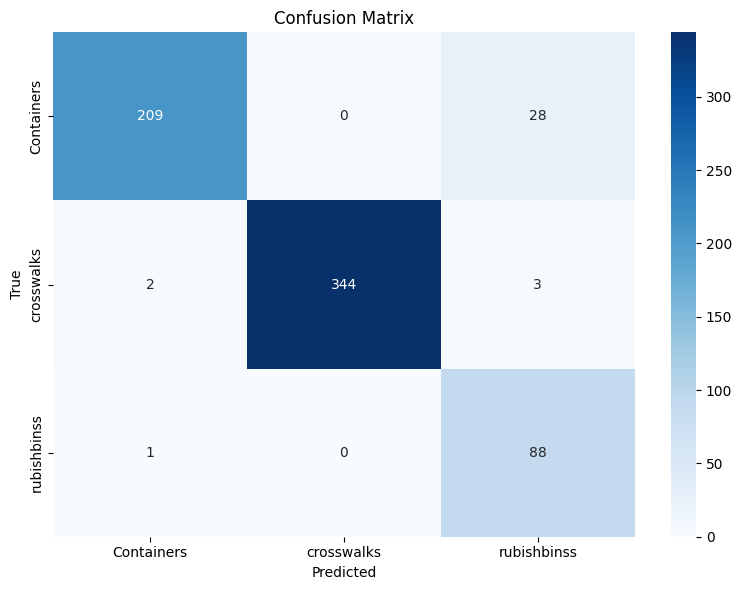

In [22]:
class_names = train_dataset.classes 

report, pred_labels, real_labels = evaluate_model(model, test_loader, class_names, device)
plot_confusion_matrix(pred_labels, real_labels, class_names)


In [23]:
torch.save(model.state_dict(), 'resnet50_weights.pth')